<a href="https://colab.research.google.com/github/studorache/MLC/blob/master/MLC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

#download data
!kaggle competitions download -c ml-challenge-week6

#unzip data
!unzip census-income.data.zip
!unzip census-income.test.zip

#create panda dataframe from training data
import pandas as pd 



Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes
  0% 0.00/769k [00:00<?, ?B/s]
100% 769k/769k [00:00<00:00, 52.6MB/s]
  0% 0.00/3.24M [00:00<?, ?B/s]
100% 3.24M/3.24M [00:00<00:00, 105MB/s]
  0% 0.00/14.5k [00:00<?, ?B/s]
100% 14.5k/14.5k [00:00<00:00, 14.6MB/s]
 70% 5.00M/7.14M [00:00<00:00, 36.6MB/s]
100% 7.14M/7.14M [00:00<00:00, 45.6MB/s]
Archive:  census-income.data.zip
  inflating: census-income.data      
Archive:  census-income.test.zip
  inflating: census-income.test      


In [0]:
initial_train_df = pd.read_csv('census-income.data', header=None,sep=',')
final_test_df = pd.read_csv('census-income.test', header=None,sep=',')

In [0]:
#get cols names
lines = open("census-income.names", "r").readlines()
i = 0
col_names = []
while i < len(lines):
    if i >= 81 and i<= 120:
      s = lines[i]
      col_names.append(s[s.find("(")+1:s.find(")")])
    i += 1
    
col_names.insert(col_names.index('detailed household summary in household')+1, 'instance weight') 

In [0]:
#Append cols list to test panda
final_test_df.columns = col_names


col_names.append('income class')
#Append cols list to train panda
initial_train_df.columns = col_names

In [0]:
categories_to_encode = ["class of worker", "education", "enroll in edu inst last wk", "marital stat", 
                       "major industry code", "major occupation code", "race", "hispanic origin", "sex", 
                       "member of a labor union", "reason for unemployment", "full or part time employment stat", 
                       "tax filer stat", "region of previous residence", "state of previous residence", 
                       "detailed household and family stat", "detailed household summary in household", 
                       "migration code-change in msa", "migration code-change in reg", 
                       "migration code-move within reg", "live in this house 1 year ago", 
                       "migration prev res in sunbelt", "family members under 18", "country of birth father", 
                       "country of birth mother", "country of birth self", "citizenship", 
                       "fill inc questionnaire for veteran's admin" ]

for cat in categories_to_encode:
  initial_train_df[cat] = initial_train_df[cat].astype('category')
  initial_train_df[cat] = initial_train_df[cat].cat.codes

for cat in categories_to_encode:
  final_test_df[cat] = final_test_df[cat].astype('category')
  final_test_df[cat] = final_test_df[cat].cat.codes


initial_train_df["income class"] = initial_train_df["income class"].astype('category')
initial_train_df["income class"] = initial_train_df["income class"].cat.codes


In [213]:
initial_train_df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,3,0,0,12,0,2,6,14,6,4,0,0,1,3,2,0,0,0,4,3,36,24,6,1700.09,0,0,0,1,0,0,4,40,40,40,4,0,1,2,0,95,0
1,58,6,4,34,16,0,2,0,4,8,4,0,1,1,3,0,0,0,0,0,4,5,20,4,1053.55,3,8,9,0,3,1,4,40,40,40,4,0,1,2,52,94,0
2,18,3,0,0,0,0,1,4,14,6,1,0,0,1,3,2,0,0,0,4,3,36,2,0,991.95,0,0,0,1,0,0,4,41,41,41,0,0,1,2,0,95,0
3,9,3,0,0,10,0,2,4,14,6,4,0,0,1,3,0,0,0,0,4,3,36,8,2,1758.14,7,6,7,2,2,0,0,40,40,40,4,0,1,0,0,94,0
4,10,3,0,0,10,0,2,4,14,6,4,0,0,1,3,0,0,0,0,4,3,36,8,2,1069.16,7,6,7,2,2,0,0,40,40,40,4,0,1,0,0,94,0


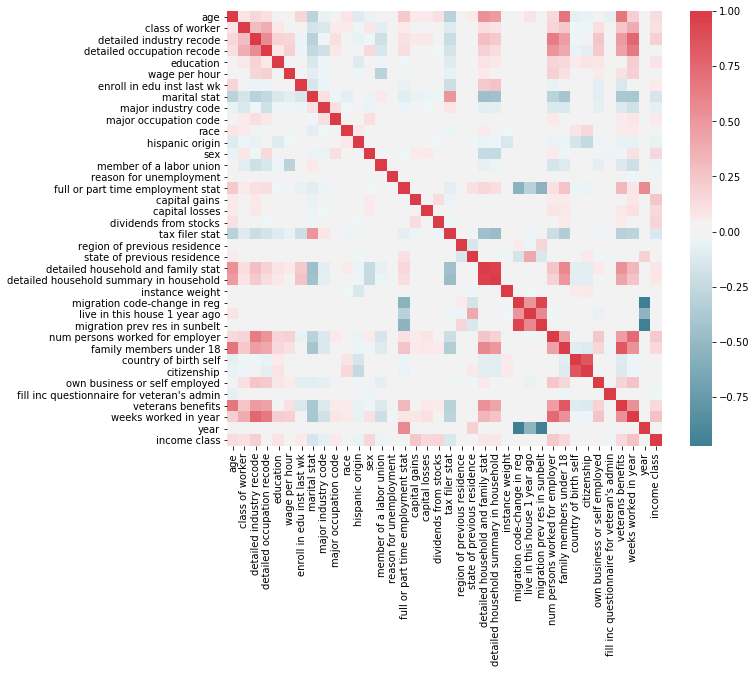

In [236]:
#remove correlated
corr = initial_train_df.corr()
import seaborn as sns
import matplotlib.pyplot as pl

f, ax = pl.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [0]:
cols_to_remove = ['country of birth mother', 'country of birth father', 'migration code-change in msa', 'migration code-move within reg']
initial_train_df=initial_train_df.drop(columns=cols_to_remove)

Find important features

In [0]:
X_set = initial_train_df.drop(['income class', 'instance weight'], axis='columns')
y_set = initial_train_df['income class']
weight_set = initial_train_df['instance weight']

rf = RandomForestClassifier() 
rf.fit(X_set, y_set,weight_set) 
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_set.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances

In [228]:
number_of_important_features = 20
important_features = feature_importances.iloc[0:number_of_important_features].index.values
important_features

array(['age', 'dividends from stocks', 'detailed occupation recode',
       'capital gains', 'education', 'detailed industry recode',
       'num persons worked for employer', 'weeks worked in year',
       'major industry code', 'major occupation code', 'sex',
       'capital losses', 'class of worker', 'tax filer stat',
       'detailed household and family stat', 'marital stat',
       'own business or self employed', 'country of birth father',
       'member of a labor union', 'country of birth mother'], dtype=object)

In [221]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_depth': list(range(5,26)), 'max_features': ['None', 'sqrt', 'log2', "int", "float"], 'criterion': ['gini', 'entropy']}

clf = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_estimators=100, random_state=42),
    param_distributions = param_grid, n_iter = 10,
    scoring='roc_auc', n_jobs=-1, cv = 5, refit=True, return_train_score = True)
clf.fit(X_set, y_set, weight_set )
clf.best_params_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt'}

In [222]:
# Predict on competition data
y_pred=clf.predict(final_test_df[important_features])


result = pd.DataFrame(y_pred)
result.columns= ['income class']
result.to_csv('result.csv', index=True, index_label='index')
!kaggle competitions submit -c ml-challenge-week6 -f result.csv -m "First try."

100% 769k/769k [00:03<00:00, 214kB/s]
Successfully submitted to ML Challenge